In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from itertools import chain
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from skimage.io import imread, imshow
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
#all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
#sample_df.sample(3)

In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
59975,00014806_000.png,No Finding,0,14806,55,F,PA,2810,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50964,00012880_026.png,No Finding,26,12880,66,M,PA,2754,2769,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
97860,00025828_001.png,No Finding,1,25828,32,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# EDA Analysis

There are multiple records in the file associated with each patient. To try and better analyze the data, we'll adjust the data to ensure we're analyzing each patient once for demographics data.

all_xray_df[all_xray_df["Follow-up #' == 0].sample(3)

In [4]:
total = len(all_xray_df)
print("total records: ", total)

for i in range(0,31):
    count = len(all_xray_df[all_xray_df['Follow-up #'] == i])
    print("With Follow-up ", i, " records: ", count, "percent: ", '{:.2f}'.format(count * 100 / total), "%")

total records:  112120
With Follow-up  0  records:  30805 percent:  27.48 %
With Follow-up  1  records:  13302 percent:  11.86 %
With Follow-up  2  records:  9189 percent:  8.20 %
With Follow-up  3  records:  7089 percent:  6.32 %
With Follow-up  4  records:  5759 percent:  5.14 %
With Follow-up  5  records:  4821 percent:  4.30 %
With Follow-up  6  records:  4034 percent:  3.60 %
With Follow-up  7  records:  3426 percent:  3.06 %
With Follow-up  8  records:  2932 percent:  2.62 %
With Follow-up  9  records:  2545 percent:  2.27 %
With Follow-up  10  records:  2225 percent:  1.98 %
With Follow-up  11  records:  1944 percent:  1.73 %
With Follow-up  12  records:  1709 percent:  1.52 %
With Follow-up  13  records:  1544 percent:  1.38 %
With Follow-up  14  records:  1363 percent:  1.22 %
With Follow-up  15  records:  1242 percent:  1.11 %
With Follow-up  16  records:  1122 percent:  1.00 %
With Follow-up  17  records:  1031 percent:  0.92 %
With Follow-up  18  records:  954 percent:  0.8

A small number of patients in the dataset have had a lot of followups.

In [5]:
all_xray_unique_df = all_xray_df[all_xray_df['Follow-up #'] == 0]

## Patient Gender

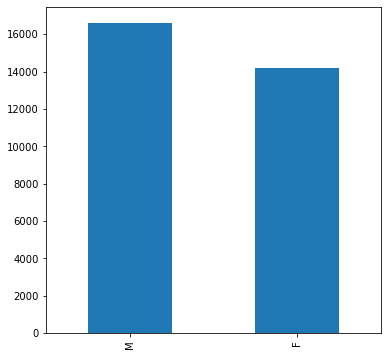

In [6]:
#First Explore Gender
plt.figure(figsize=(6,6))
all_xray_unique_df['Patient Gender'].value_counts().plot(kind='bar')

In [7]:
#len(all_xray_df)
print("Male Percentage: ", '{:.2f}'.format(len(all_xray_unique_df[all_xray_unique_df['Patient Gender'] == 'M']) / len(all_xray_unique_df)))
print("Female Percentage: ", '{:.2f}'.format(len(all_xray_unique_df[all_xray_unique_df['Patient Gender'] == 'F']) / len(all_xray_unique_df)))

Male Percentage:  0.54
Female Percentage:  0.46


A significant percentage difference between male and female in the database. For the training, we'll need to ensure this is better balanced for training consistency.

## Analyze Patient Age

(array([1.2106e+04, 1.8578e+04, 1.1300e+02, 6.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1. ,  42.1,  83.2, 124.3, 165.4, 206.5, 247.6, 288.7, 329.8,
        370.9, 412. ]),
 <a list of 10 Patch objects>)

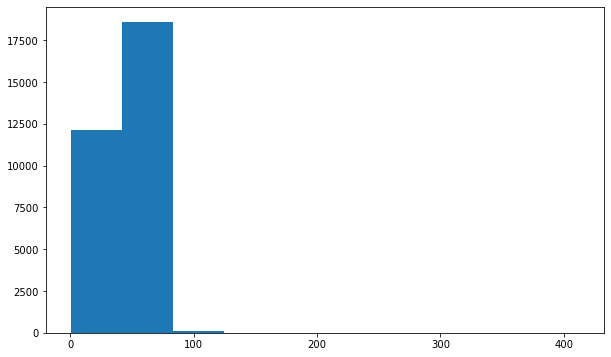

In [8]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_unique_df['Patient Age'])

Looks to be a bad data element. Let's find it and remove it from consideration.

In [9]:
print("Max age in data set: ", all_xray_unique_df['Patient Age'].max())
print("Count of ages above 130: ", len(all_xray_unique_df[all_xray_unique_df['Patient Age'] > 130]))
all_xray_unique_df[all_xray_unique_df['Patient Age'] > 130]['Patient Age']

Max age in data set:  412
Count of ages above 130:  8


20852     412
55742     148
62929     149
78795     151
91369     412
95794     153
101194    155
104590    155
Name: Patient Age, dtype: int64

When creating the testing and validation data sets, the patients with bad age data needs to be removed from consideration.

(array([ 666., 1283., 3652., 4325., 5329., 7278., 5111., 2514.,  577.,
          62.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

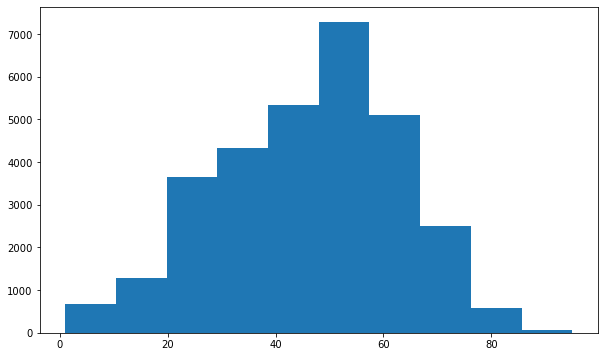

In [10]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_unique_df[all_xray_unique_df['Patient Age'] < 130]['Patient Age'])

The majority of the data is between the ages of 20 and 80. We could stretch the data to 10 because we have about 1000 patients down to 10 years old whichs is the same amount of data at 80.

## Analyze View Position

PA and AP are significantly different in proportions for different parts of the x-ray. Most notably the heart as referenced here:
Chest X-Ray : https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection


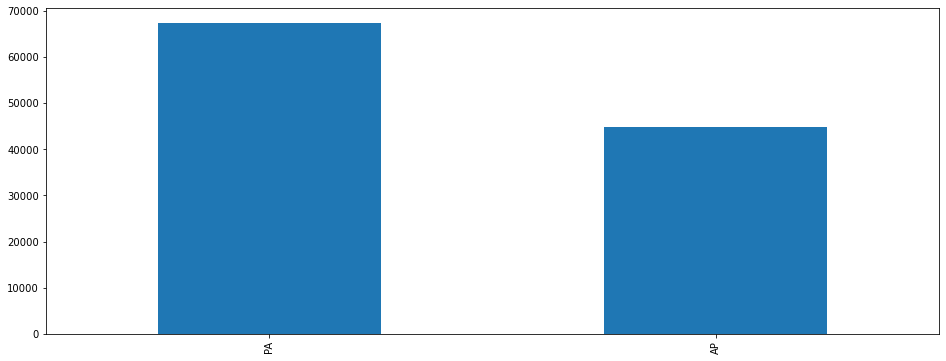

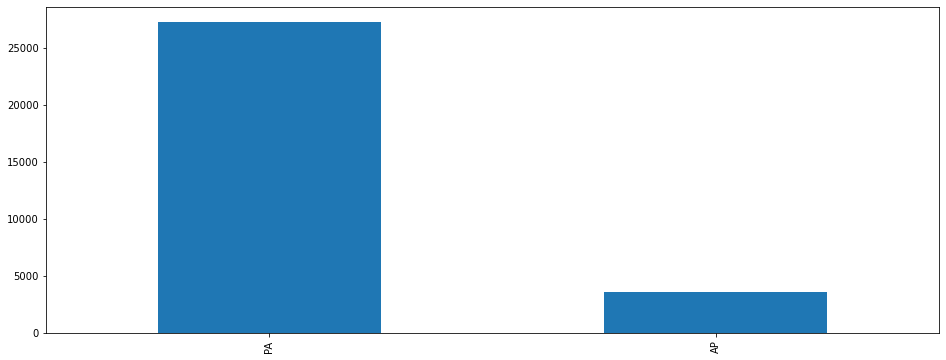

In [11]:
# The patient demographic data such as patient position,etc. (as it is available) 

# We should evaluate the entire set of data and then specifically just the first x-ray for the unique patients.

plt.figure(figsize=(16,6))
all_xray_df['View Position'].value_counts()[0:30].plot(kind='bar')

plt.figure(figsize=(16,6))
all_xray_unique_df['View Position'].value_counts()[0:30].plot(kind='bar')

The total data base a significant number of AP images. However the first image for people with no followup is highly skewed to the PA view position. We need to consider if we will support AP and PA images or just PA evaluation. This comes down to if we're trying to provide a scanning algorithm or a diagnostic algorithm. Will check if there is a signifcant difference in pneumonia diagnosis between PA and AP view positions.

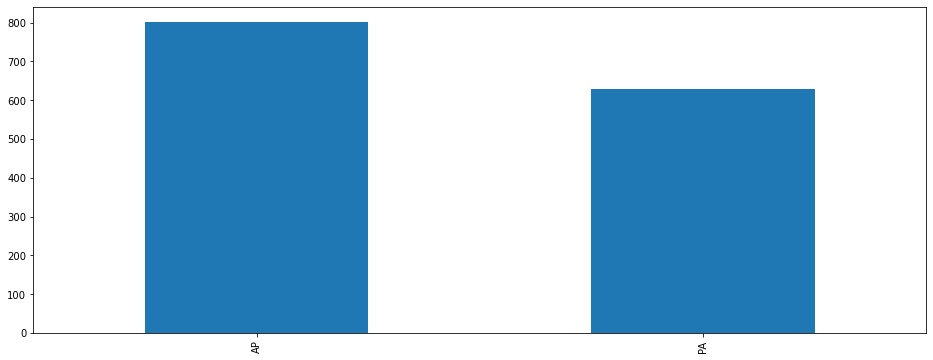

In [12]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts()[0:30].plot(kind='bar')

## Number of Cases Analysis

The number of cases including:
  number of pneumonia cases,
  number of non-pneumonia cases
  
We'll explore the entire data set.

In [13]:
len(all_labels)

15

There are 15 different labels in the data set.

In [14]:
total_pneumonia = len(all_xray_df[(all_xray_df.Pneumonia==1)])
print('total_pneumonia: ', total_pneumonia)
print('total_non_pneumonia: ', len(all_xray_df[(all_xray_df.Pneumonia==0)]))
print('')

label_percents = all_xray_df[all_labels].sum()/len(all_xray_df) * 100
pd.options.display.float_format = '{:,.2f}%'.format
print(label_percents)

total_pneumonia:  1431
total_non_pneumonia:  110689

Atelectasis          10.31%
Cardiomegaly          2.48%
Consolidation         4.16%
Edema                 2.05%
Effusion             11.88%
Emphysema             2.24%
Fibrosis              1.50%
Hernia                0.20%
Infiltration         17.74%
Mass                  5.16%
No Finding           53.84%
Nodule                5.65%
Pleural_Thickening    3.02%
Pneumonia             1.28%
Pneumothorax          4.73%
dtype: float64


The breakout by percentage is above.

[Text(0, 0.5, 'Number of Images with Label')]

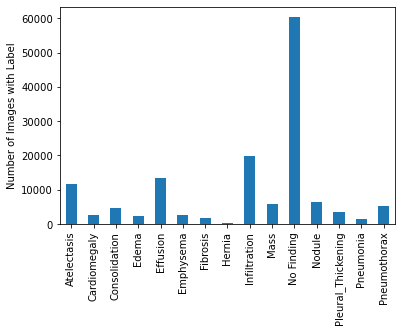

In [15]:
# number of pneumonia cases and non-pneumonia cases

ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The most frequently occuring result is 'No Finding' at 53.84% occurance. So that percentage of the database would have no other label associated. Beyond that the most common labels are: Infiltration (17.74%), Effusion (11.88%), and Atelectasis (10.31%). Pnemonia which is what we eventually want to detect only labeled in 1.28% of images.         

Next we'll see if Pnemonia has any common comorbid relations.

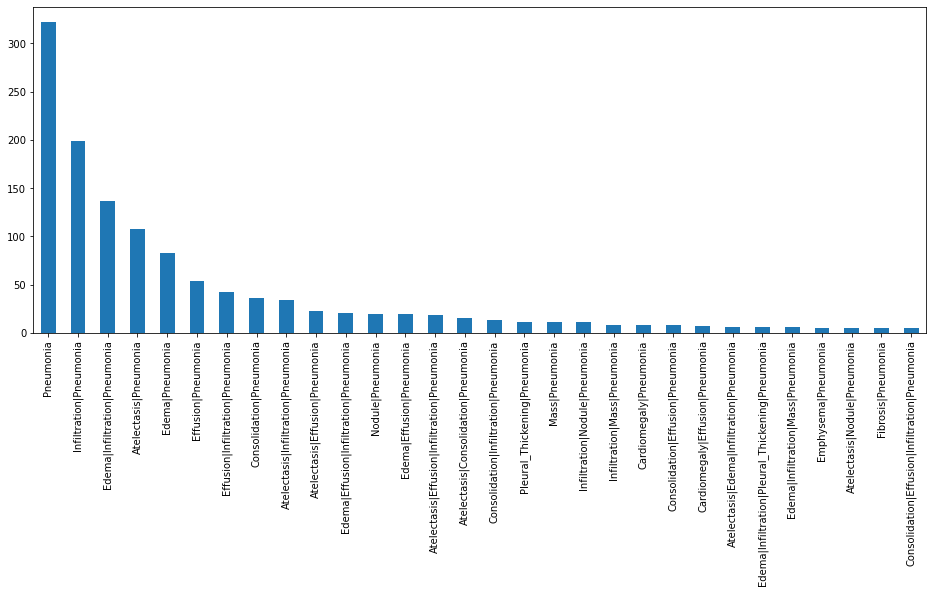

In [16]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common comorbid relations:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

There is a lot of comorbid here with Pneumonia. Let's see if we can determine how often the other labels occur if there is also a Penumonia assessment.

In [17]:
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30]

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  54
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Nodule|Pneumonia                                    19
Edema|Effusion|Pneumonia                            19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Pleural_Thickening|Pneumonia                        11
Mass|Pneumonia                                      11
Infiltrati

In [18]:
total_only_pneumonia = all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30]['Pneumonia']

In [19]:
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30] / total_pneumonia * 100

Pneumonia                                         22.50%
Infiltration|Pneumonia                            13.91%
Edema|Infiltration|Pneumonia                       9.57%
Atelectasis|Pneumonia                              7.55%
Edema|Pneumonia                                    5.80%
Effusion|Pneumonia                                 3.77%
Effusion|Infiltration|Pneumonia                    2.94%
Consolidation|Pneumonia                            2.52%
Atelectasis|Infiltration|Pneumonia                 2.38%
Atelectasis|Effusion|Pneumonia                     1.61%
Edema|Effusion|Infiltration|Pneumonia              1.47%
Nodule|Pneumonia                                   1.33%
Edema|Effusion|Pneumonia                           1.33%
Atelectasis|Effusion|Infiltration|Pneumonia        1.26%
Atelectasis|Consolidation|Pneumonia                1.05%
Consolidation|Infiltration|Pneumonia               0.91%
Pleural_Thickening|Pneumonia                       0.77%
Mass|Pneumonia                 

For all pneumonia cases Inflitration and Pneumonia occur 61.80% of the time. However there are also other label combinations that include Inflitration as well. It is clear that for Pneumonia there are very often other findings. 

In [20]:
'{:,.2f}%'.format(total_only_pneumonia / total_pneumonia * 100)

'22.50%'

Only 22.50% of cases are pneumonia and no other finding.

In [21]:
co_occ = pd.DataFrame(columns=['Label', 'With Pneumonia'])

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        #print(c_label, '{:,.2f}%'.format(len(all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df[c_label]==1)]) / total_pneumonia * 100))
        co_occ = co_occ.append({'Label': c_label, 'With Pneumonia': len(all_xray_df[(all_xray_df.Pneumonia==1) & (all_xray_df[c_label]==1)]) / total_pneumonia * 100 }, ignore_index=True)

co_occ.sort_values(by='With Pneumonia', ascending=False)

,Label,With Pneumonia
13,Pneumonia,100.00%
8,Infiltration,42.28%
3,Edema,23.76%
4,Effusion,18.80%
0,Atelectasis,18.31%
2,Consolidation,8.60%
9,Mass,4.96%
11,Nodule,4.89%
12,Pleural_Thickening,3.35%
1,Cardiomegaly,2.87%


Pneumonia cases have high occurances of Inflitration (42.28%), Edema (23.76%), Effusion (18.80%), and Atelectasis (18.31%).

## Number of disease per patient

In [22]:
pd.options.display.float_format = '{:,.0f}'.format
pre_grouped = all_xray_df[['Patient ID', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]
grouped = pre_grouped.groupby(['Patient ID'])

grouped = grouped.sum()
grouped['count'] = 0

for c_label in all_labels:
    if len(c_label)>1 and c_label != 'No Finding': # le#ave out empty labels
        grouped['count'] += np.where(grouped[c_label] > 0, 1, 0)
    
disease_counts = grouped.filter(items=['Patient ID', 'count'])
disease_counts['count'].value_counts()

0     16403
1      6742
2      2908
3      1638
4      1087
5       707
6       518
7       335
8       205
9       139
10       84
11       28
12        7
13        4
Name: count, dtype: int64

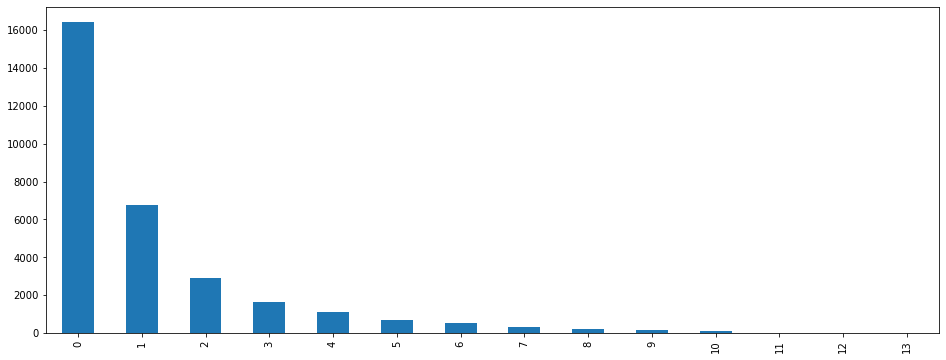

In [23]:
plt.figure(figsize=(16,6))
disease_counts['count'].value_counts()[0:30].plot(kind='bar')

We can see in the graph an exponential drop off with the number of diseases for patients. 

## Pixel-level assessment

Let's determine the mean and standard deviation across all the images for each of the conditions.
For this we'll use the sample data which is only 5605 images.

In [24]:
len(sample_df)

5606

In [25]:
all_sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_sample_labels = [x for x in all_sample_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_sample_labels), all_sample_labels))
for c_label in all_sample_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Mapping the path into the sample data set so each image can be retrieved and analyzed.

In [26]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
2103,00010815_021.png,Nodule,21,10815,067Y,M,PA,2500,2048,0,...,0,0,0,0,0,1,0,0,0,/data/images_005/images/00010815_021.png
817,00004338_002.png,Edema,2,4338,050Y,M,AP,2500,2048,0,...,0,0,0,0,0,0,0,0,0,/data/images_003/images/00004338_002.png
3011,00014794_000.png,No Finding,0,14794,057Y,F,PA,2410,2991,0,...,0,0,0,0,1,0,0,0,0,/data/images_007/images/00014794_000.png


Developed the below function to retrieve all the images from a given dataframe and average them together. This winds up creating a histomgram that matches the standard deviation histogram.

There were images that were taken using RGBa. To process them, given RGB were all the same and the a channel was opaque, reducing the images to a signle intensity channel allowed adding the images to the processing.

In [50]:
def show_disease_intensity_charts(c_label):

    if (len(c_label) > 0):
        sample_disease_df = sample_df.where(sample_df[c_label] == 1.0).dropna()
    else:
        sample_disease_df = sample_df

    all_img = np.zeros((1024,1024))
    count = 0

    for index, row in sample_disease_df.iterrows():
        img = imread(row['path'])
        if len(np.shape(img)) > 2:
            img = img[:,:,0]               # reduce back to (1024,1024) image    
        all_img = np.add(all_img, img)
        count += 1

    print('Total Images: ', count)

    all_avg_img = all_img / count    
    
    plt.figure(figsize=(5,5))
    plt.hist(all_avg_img.ravel(), bins = 256)    

    mean_intensity = np.mean(all_avg_img)
    std_intensity = np.std(all_avg_img)
    print('Mean Intensity:', mean_intensity)
    print('Std Deviation Intensity:', std_intensity)
    dev_img = all_avg_img
    dev_img = (dev_img - mean_intensity)/std_intensity    

    plt.figure(figsize=(5,5))
    plt.hist(dev_img.ravel(), bins = 256)    

[Text(0, 0.5, 'Number of Images with Label')]

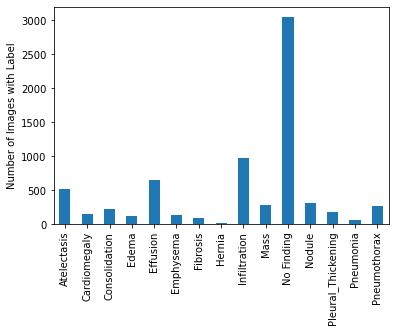

In [51]:
ax = sample_df[all_sample_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Analyzing the top 4 diseases and pneumonia along with the "No Finding" label will help identify if intensity stands out.

Total Images:  3044
Mean Intensity: 129.19650772022044
Std Deviation Intensity: 43.13135106581009


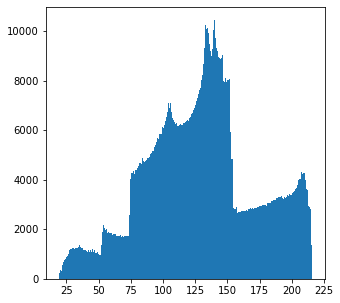

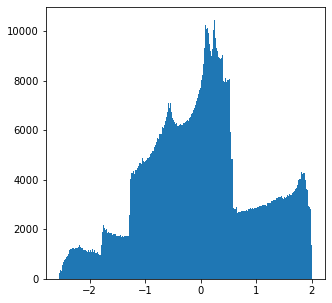

In [39]:
show_disease_intensity_charts('No Finding')

Total Images:  967
Mean Intensity: 121.27387230941162
Std Deviation Intensity: 42.853500686765145


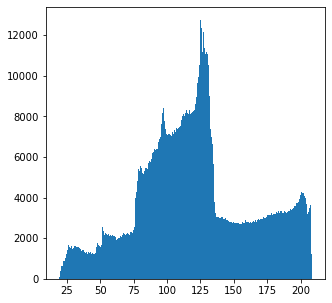

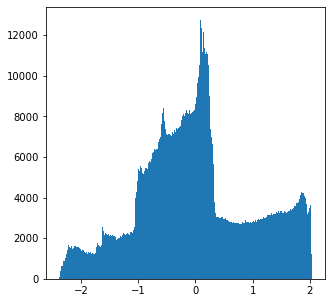

In [40]:
show_disease_intensity_charts('Infiltration')

Total Images:  644
Mean Intensity: 124.07889403171416
Std Deviation Intensity: 45.51375972128822


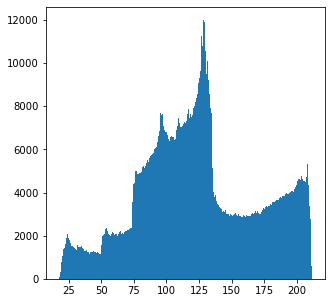

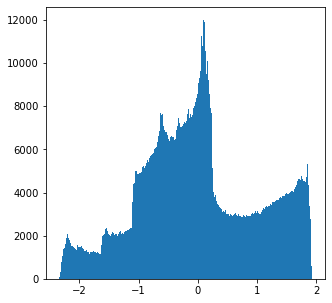

In [41]:
show_disease_intensity_charts('Effusion')

Total Images:  508
Mean Intensity: 128.0867545998941
Std Deviation Intensity: 43.93821103728621


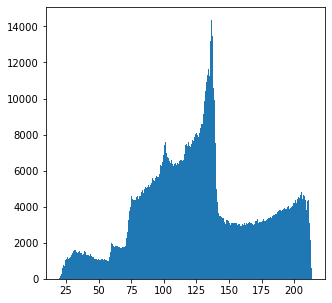

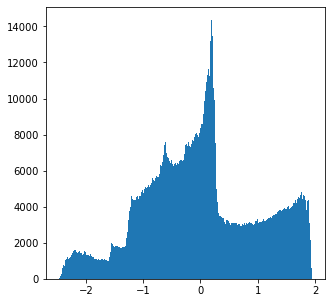

In [42]:
show_disease_intensity_charts('Atelectasis')

Total Images:  271
Mean Intensity: 120.7820586630339
Std Deviation Intensity: 43.40158859986373


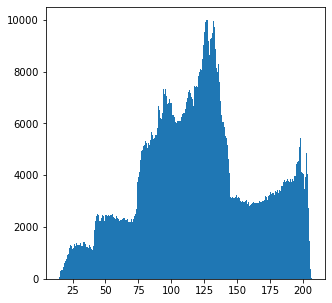

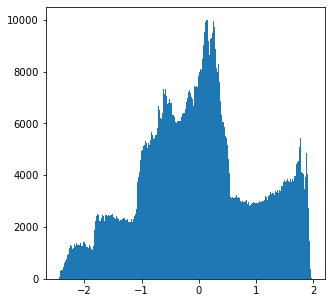

In [43]:
show_disease_intensity_charts('Pneumothorax')

Total Images:  62
Mean Intensity: 125.13923225095192
Std Deviation Intensity: 42.70226101292348


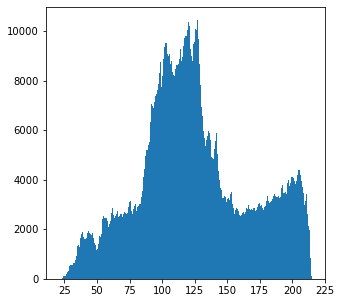

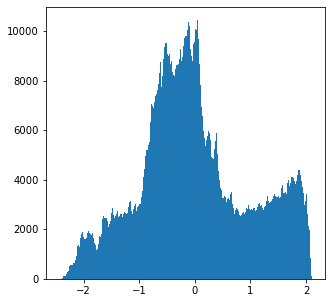

In [44]:
show_disease_intensity_charts('Pneumonia')

The intensities are far too close overall to make judgements across the entire x-ray image for differentiation of diseases. This makes some common sense as many diseases are only a small part of the overall image.

There are some slight differences. For example around -1 std on pneumonia there is a quick drop off in intensity. While the 'No Findings' also has a drop off between -1 and 0 are far more nuanced structures than in the pneumonia aggregate data. This could be a way to differentiate pneumonia from a 'No Finding' analysis. The other obvious element here also is 

In [35]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
24805,00006517_004.png,Consolidation,4,6517,45,F,AP,2500,2048,0,0,nan,/data/images_003/images/00006517_004.png
36704,00009665_002.png,No Finding,2,9665,71,M,AP,2500,2048,0,0,nan,/data/images_005/images/00009665_002.png
18389,00004893_043.png,Atelectasis,43,4893,31,M,PA,2992,2991,0,0,nan,/data/images_003/images/00004893_043.png


of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.